Em là vòng nguyệt quế, anh muốn chạm một đời chơi vơi
Say à ha hà há, -'-'--` vui  sống trọn lạc miền  cõi tiên
Em đàn anh hát, âm vang giữa núi cao chập chùng 
Trăng tròn rồi khuyết, tháng ngày ngày tháng tháng ngày yêu 

Hát tưởng cho vui thôi nhưng mình  cứ say hoài 
Làm sao ta nói hết đây, tâm tư còn mãi đong đầy
Lời  yêu `--`' gọi vẫn chưa tròn tiếng
Phút giây mong chờ  - giây phút chờ mong

Nàng là công chúa, giúp  ta tô thêm phấn son đời thường
Say ồ hô hố, rót thêm nào thêm lại càng thêm

Anh hát lá diêu bông, em tôi   đừng chạnh lòng
Chỉ  lời người cũ mà thôi, trái tim  anh vốn  tỏ  lắm rồi
Hoa vẫn hồng thắm sân vườn đây đó
Dẫu cát bụi sẽ  gọi tên bốn mùa

Sao mi em khóc, để lệ tràn thành hồ nước long lanh
Xưa bờ cỏ non, ``-`-`' bờ mộng mị ta  lại cùng nhau 
Anh đàn em hát, ngân nga thương yêu dịu  lành
Mây bồng bềnh nắng, lướt du hành biếc triều  triền miên

Nắm lấy tay nhau là thế giang nay vui rồi
Cần chi biển rộng người ơi
Khoảnh khắc duy nhất trong đời 
Có nhau là hơn tất cả
Lướt tới vẫy trời bao la …

In [1]:
import math, random
import gym
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical

from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

import lib
from strat_macrossover import *

In [2]:
torch.manual_seed(51)

In [5]:
ticker = 'AAPL'
start_date = datetime(2015,1,1)
end_date = datetime(2020,1,1)
df = web.DataReader(ticker, 'yahoo', start_date, end_date)
df_open = df['Open']
df_close = df['Close']

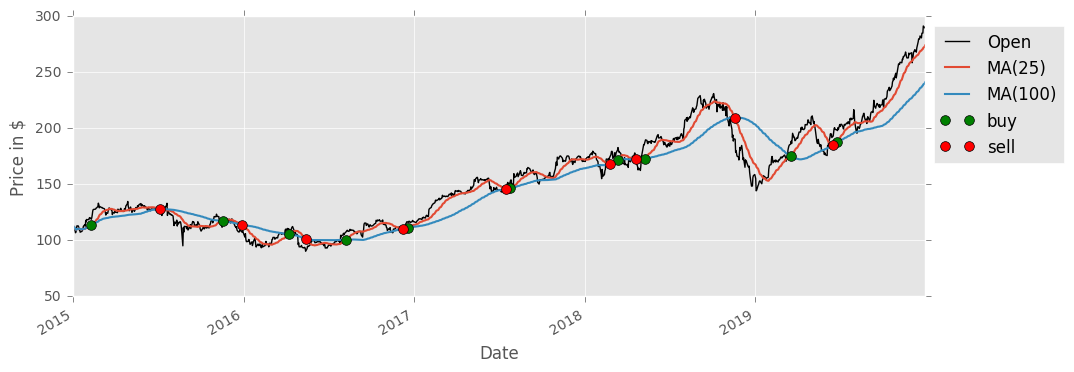

In [4]:
commission = 0.0015
interval = 'daily'
paras = {'df': df, 'commission': commission, 'interval': interval, 'short_window': 25, 'long_window': 100} 
signals = find_signal(paras)
plot_strat(signals, paras)

# Build the environment

* For starting cash, we can't use a dollar value because of the transformed data. After shifting earlier, we know the mean of each opening price should be 35, so I'm starting the agent off with enough cash to buy ~2.5 shares.
* This starting cash is the mean starting cash; it can be randomized by altering the std parameter
* action space = 0 buy apple, 1 sell apple, 2 do nothing, 3 buy msft, 4 sell msft, quantity. eg. [0, 100]
* obs space: apl shares, msft shares, cash in bank [2], today apl open [3], today msf open [4], portfolio value [5], 5 day window [6apl, 7msf] = 8
* If bot gets to the end with more than one of each share, we give it a bonus for having a diversified portfolio!
* Buys and sells attract a 0.15% brokerage fee

In [ ]:
class TradingEnvironment():

    def __init__(self, max_stride=10, starting_cash, series_length=150, starting_point=1, inaction_penalty=0., \
                 ma_short_window = 25, ma_long_window = 100):
        self.num_input = 6
        self.starting_cash = starting_cash
        self.ma_short_window = ma_short_window
        self.ma_long_window = ma_long_window
        
        self.state = torch.FloatTensor(torch.zeros(self.num_input))
        
        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point
        
        self.state[0] = 0
        self.starting_portfolio_value = self.portfolio_value()
        self.state[1] = self.starting_cash
        self.state[2] = df_open[self.cur_timestep]
        self.state[3] = self.starting_portfolio_value
        self.state[4] = self.five_day_window()[0]
    
        paras = {'df': df, 'commission': inaction_penalty, 'interval': 'daily', \
                 'short_window': self.ma_short_window, 'long_window': self.ma_long_window} 
        self.signals = find_signal(paras)
        self.state[5] = 0.0
        
        self.stride = max_stride # no longer varying it
        
        self.done = False
        self.diversification_bonus = 0
        self.inaction_penalty = inaction_penalty
    
    def portfolio_value(self):
        return (self.state[0] * apl_close[self.cur_timestep]) + self.state[1]
    
    def next_opening_price(self):
        step = self.cur_timestep + self.stride
        return [df_open[step]]
    
    def five_day_window(self):
        step = self.cur_timestep
        if step < 5:
            return [df_open[0]]
        df5 = df_open[step-5:step].mean()
        return [df5]
        
    def step(self, action):
        action = [action, 1.] # buy/sell 1 share each time
        cur_timestep = self.cur_timestep
        ts_left = self.series_length - (cur_timestep - self.starting_point)
        retval = None
        cur_value = self.portfolio_value()
        gain = cur_value - self.starting_portfolio_value
        
        if cur_timestep >= self.starting_point + (self.series_length * self.stride):
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window(), \
                        self.apl_signals['position'][cur_timestep], self.msf_signals['position'][cur_timestep]]
            self.state = new_state
            bonus = 0.
            if self.state[0] > 0 and self.state[1] > 0:
                bonus = self.diversification_bonus
            return new_state, cur_value + bonus + gain, True, { "msg": "done"}
        
        if action[0] == 2:
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window(), \
                        self.apl_signals['position'][cur_timestep], self.msf_signals['position'][cur_timestep]]
            self.state = new_state
            retval = new_state, -self.inaction_penalty-ts_left +gain, False, { "msg": "nothing" }
            
        if action[0] == 0:
            if action[1] * apl_open[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                            cur_value, *self.five_day_window(), \
                            self.apl_signals['position'][cur_timestep], self.msf_signals['position'][cur_timestep]]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"}
            else:
                apl_shares = self.state[0] + action[1]
                cash_spent = action[1] * apl_open[cur_timestep] * 1.1 #10% brokerage fee
                new_state = [apl_shares, self.state[1], self.state[2] - cash_spent, *self.next_opening_price(), \
                            cur_value, *self.five_day_window(), \
                            self.apl_signals['position'][cur_timestep], self.msf_signals['position'][cur_timestep]]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought AAPL"}
                
        if action[0] == 3:
            if action[1] * msf_open[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                            cur_value, *self.five_day_window(), \
                            self.apl_signals['position'][cur_timestep], self.msf_signals['position'][cur_timestep]]
                self.state = new_state
                retval =  new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"}
            else:
                msf_shares = self.state[1] + action[1]
                cash_spent = action[1] * msf_open[cur_timestep] * 1.1 #10% brokerage fee
                new_state = [self.state[0], msf_shares, self.state[2] - cash_spent, *self.next_opening_price(), \
                            cur_value, *self.five_day_window(), \
                            self.apl_signals['position'][cur_timestep], self.msf_signals['position'][cur_timestep]]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought MSFT"}
        

        if action[0] == 1:
            if action[1] > self.state[0]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                            cur_value, *self.five_day_window(), \
                            self.apl_signals['position'][cur_timestep], self.msf_signals['position'][cur_timestep]]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                apl_shares = self.state[0] - action[1]
                cash_gained = action[1] * apl_open[cur_timestep] * 0.9
                new_state = [apl_shares, self.state[1], self.state[2] + cash_gained, *self.next_opening_price(), \
                            cur_value, *self.five_day_window(), \
                            self.apl_signals['position'][cur_timestep], self.msf_signals['position'][cur_timestep]]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold AAPL"}
                
        if action[0] == 4:
            if action[1] > self.state[1]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                            cur_value, *self.five_day_window(), \
                            self.apl_signals['position'][cur_timestep], self.msf_signals['position'][cur_timestep]]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                msf_shares = self.state[1] - action[1]
                cash_gained = action[1] * msf_open[cur_timestep] * 0.9
                new_state = [self.state[0], msf_shares, self.state[2] + cash_gained, *self.next_opening_price(), \
                            cur_value, *self.five_day_window(), \
                            self.apl_signals['position'][cur_timestep], self.msf_signals['position'][cur_timestep]]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold MSFT"}
                
        self.cur_timestep += self.stride
        return retval
    
    def reset(self):
        self.state = torch.FloatTensor(torch.zeros(self.num_input))
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        self.cur_timestep = self.starting_point
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[2] = self.starting_cash
        self.state[3] = apl_open[self.cur_timestep]
        self.state[4] = msf_open[self.cur_timestep]
        self.starting_portfolio_value = self.portfolio_value()
        self.state[5] = self.starting_portfolio_value
        self.state[6] = self.five_day_window()[0]
        self.state[7] = self.five_day_window()[1] 
        self.state[8] = 0.0
        self.state[9] = 0.0
        self.done = False
        return self.state

In [ ]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.num_input = 10
        self.input_layer = nn.Linear(self.num_input, 128)
        self.hidden_1 = nn.Linear(128, 128)
        self.hidden_2 = nn.Linear(32,31)
        self.hidden_state = torch.tensor(torch.zeros(2,1,32))
        self.rnn = nn.GRU(128, 32, 2)
        self.action_head = nn.Linear(31, 5)
        self.value_head = nn.Linear(31, 1)
        self.saved_actions = []
        self.rewards = []

    def reset_hidden(self):
        self.hidden_state = torch.tensor(torch.zeros(2,1,32))
        
    def forward(self, x):
        x = torch.tensor(x)
        x = torch.sigmoid(self.input_layer(x))
        x = torch.tanh(self.hidden_1(x))
        x, self.hidden_state = self.rnn(x.view(1,-1,128), self.hidden_state.data)
        x = F.relu(self.hidden_2(x.squeeze()))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze()
        if action == 4 and env.state[1] < 1: action = torch.LongTensor([2]).squeeze()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

In [ ]:
env = TradingEnvironment(max_stride=10, series_length=150, starting_cash_mean=1000, randomize_cash_std=0, starting_shares_mean=100, randomize_shares_std=0, \
                        ma_short_window = 25, ma_long_window = 100)
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
env.reset()
# In case you're running this a second time with the same model, delete the gradients
del model.rewards[:]
del model.saved_actions[:]

gamma = 0.9
log_interval = 60

def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []
    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        rewards.insert(0, R)
    rewards = torch.tensor(rewards)
    
    epsilon = (torch.rand(1) / 1e4) - 5e-5
    # With different architectures, I found the following standardization step sometimes
    # helpful, sometimes unhelpful.
    # rewards = (rewards - rewards.mean()) / (rewards.std(unbiased=False) + epsilon)
    # Alternatively, comment it out and use the following line instead:
    rewards += epsilon
    
    for (log_prob, value), r in zip(saved_actions, rewards):
        reward = torch.tensor(r - value.item())
        policy_losses.append(-log_prob * reward)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([r])))
        
    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss = torch.clamp(loss, -1e-5, 1e5)
    loss.backward()
    optimizer.step()
    del model.rewards[:]
    del model.saved_actions[:]

running_reward = 0
for episode in range(0, 4000):
    state = env.reset()
    reward = 0
    done = False
    msg = None
    while not done:
        action = model.act(state)
        state, reward, done, msg = env.step(action)
        model.rewards.append(reward)
        if done:
            break
    running_reward = running_reward * (1 - 1/log_interval) + reward * (1/log_interval)
    finish_episode()
    # Resetting the hidden state seems unnecessary - it's effectively random from the previous
    # episode anyway, more random than a bunch of zeros.
    # model.reset_hidden()
    if msg["msg"] == "done" and env.portfolio_value() > env.starting_portfolio_value * 1.1 and running_reward > 500:
        print("Early Stopping: " + str(int(reward)))
        break
    if episode % log_interval == 0:
        print("""Episode {}: started at {:.1f}, finished at {:.1f} because {} @ t={}, \
last reward {:.1f}, running reward {:.1f}""".format(episode, env.starting_portfolio_value, \
              env.portfolio_value(), msg["msg"], env.cur_timestep, reward, running_reward))